In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [2]:
pd.options.display.max_columns = 999
gr      = 1.618
flux_corr = 1.028

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
# Minimum reconstructable energies:
min_e = 0.02 + mass_e # 20MeV
min_p = 0.04 + mass_p # 40MeV
min_pi = 0.17

outdir = "../../Output/flash_validation/"

In [3]:
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

In [28]:
# Options, pick your favorite: 
# name of the file, number of events unweighted, POT, nglect bnbweight?, eventstotal reweighted, window start, label

nu =          ("nu"         , 197400, 1.99831691626e+20, 0, 194478*flux_corr, 3.16, "Default MC")
nu_tune3 =    ("nu_tune3"   , 392000, 4.24442569577e+20, 0, 386038*flux_corr, 3.16, "Genie Alternative")
nu_overlaid = ("nu_overlaid", 198260, 2.06428890689e+20, 1, 198260*flux_corr, 3.58, r"MC $\nu$ + Cosmic Data")
nu_cv =       ("nu_induced" ,  90700, 9.16447375224e+19, 0,  89359*flux_corr, 3.16, "Dynamic Induced Charge")
nu_lightbug = ("nu_lightbug",  90050, 9.10927647885e+19, 0,  88711*flux_corr, 3.16, "Improved Light Yield")

allnu = [nu, nu_tune3, nu_overlaid, nu_cv, nu_lightbug]
ext_scale = 9779224/14255249
bnb_pot = 4.413e19 # needed to normalise the other samples to 4e19

In [5]:
df_arr = []
df_candidate_arr = []

for sample in allnu:
    print("loading dataframe",sample[0],"with",sample[1],"events.")
    df_arr.append(pd.read_pickle("./input/df_"+sample[0]+"_flash.pckl"))
    df_candidate_arr.append(pd.read_pickle("./input/df_"+sample[0]+"_flash_candidate.pckl"))
    if sample[3]: # set weigths manual for overlaid sample
        df_arr[-1]["bnbweight"] = flux_corr
        df_candidate_arr[-1]["bnbweight"] = flux_corr
    else:
        df_arr[-1]["bnbweight"] *= flux_corr
        df_candidate_arr[-1]["bnbweight"] *= flux_corr

loading dataframe nu with 197400 events.
loading dataframe nu_tune3 with 392000 events.
loading dataframe nu_overlaid with 198260 events.
loading dataframe nu_induced with 90700 events.
loading dataframe nu_lightbug with 90050 events.


In [6]:
data_off = pd.read_pickle("./input/df_bnbext_a_flash.pckl")
data_on = pd.concat([pd.read_pickle("./input/df_bnb_a_flash.pckl"),pd.read_pickle("./input/df_bnb_b_flash.pckl")])

data_off["bnbweight"] = ext_scale
data_on["bnbweight"] = 1

In [7]:
mc_start = 3.16
bnb_start = 3.19     # mc_start + 2*0.015625 #3.20
ext_start = 3.58     # mc_start + 26*0.015625 #3.58
intime_start = 3.58  # mc_start + 26*0.015625 # 3.58
duration = 1.68

In [8]:
# Parameters to geth the data mc ration in the right spot
ratio_x = 0.70
ratio_y = 8./9
ratio_text = r"$\frac{Beam \ ON}{Beam \ OFF + MC} = $"

36


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:87: RuntimeWarning: divide by zero encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


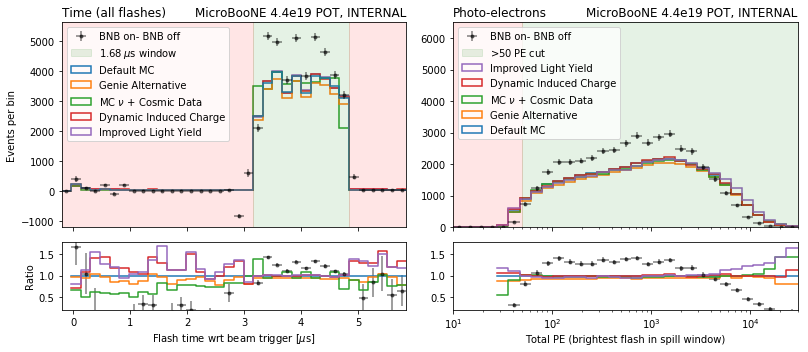

In [30]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0.2
y_r_max=1.8

#Left plot
x_min = -0.2
x_max = 8.2-0.168*14
N= round((x_max-x_min)/0.168)
print(N)
bhalf = (x_max-x_min)/(2*N)

flash_arr = []
weight_arr = []
for sample, df in zip(allnu, df_arr):
    flash_arr.append(np.hstack(df["flash_time"])-(sample[5]-mc_start))
    weight_arr.append([sample[4]/sample[1]*bnb_pot/sample[2]]*len(flash_arr[-1]))

#if we are using overlaid instead of MC, we use # -(ext_start-mc_start)
bins,edges,_ = ax[0][0].hist(flash_arr,bins=N,range=(x_min,x_max), histtype='step', 
                             weights=weight_arr, label=[i[6] for i in allnu],lw=1.5) 

bnb_on, _ = np.histogram(np.hstack(data_on["flash_time"])-(bnb_start-mc_start),bins=N,range=(x_min,x_max))
bnb_off_values = np.hstack(data_off["flash_time"])-(ext_start-mc_start) 
bnb_off_weights = [ext_scale]*len(bnb_off_values)
bnb_off, _ = np.histogram(bnb_off_values ,bins=N,range=(x_min,x_max), weights=bnb_off_weights) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(bnb_off_values.tolist(),bnb_off_weights,edges))**2)
ax[0][0].errorbar(edges[:-1]+bhalf, bnb_on-bnb_off, xerr=bhalf, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on- BNB off")

ax[0][0].axvspan(x_min,mc_start, alpha=0.1, color="red")
ax[0][0].axvspan(mc_start,mc_start+duration, alpha=0.1, color="green",label=str(duration)+"$\: \mu$s window" )
ax[0][0].axvspan(mc_start+duration,x_max, alpha=0.1, color="red")

ax[0][0].set_title(r"Time (all flashes)", loc='left')
ax[0][0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[1][0].set_xlabel(r"Flash time wrt beam trigger [$\mu$s]")
ax[0][0].set_ylabel(r"Events per bin")
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc="upper left")
ax[0][0].set_xlim(x_min,x_max)

ratios = bins/bins[0]
ax[1][0].errorbar(edges[:-1]+bhalf, (bnb_on-bnb_off)/bins[0], xerr=bhalf, yerr=err_on_off/bins[0] ,alpha=0.5, color= "k", fmt=".")
for sample, ratio in zip(allnu, ratios):
    ax[1][0].plot(edges[1:],ratio,ls='steps')
    
ax[1][0].set_ylabel('Ratio')
ax[1][0].set_ylim(y_r_min,y_r_max)


# Right plot
x_min = 10
x_max = 30000
N=32
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
y_max = 6500
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]

bins_arr= []
for sample, df in zip(allnu, df_arr):
    bins,_,_ = ax[0][1].hist(df.query("flash_PE_max>1")["flash_PE_max"],bins=edges, histtype='step', 
                             weights=df.query("flash_PE_max>1")["bnbweight"]*bnb_pot/sample[2], label=sample[6],lw=1.5)
    bins_arr.append(bins)

bnb_on, _ = np.histogram(data_on.query("flash_PE_max>1")["flash_PE_max"],bins=edges,range=(x_min,x_max))
bnb_off_values = data_off.query("flash_PE_max>1")["flash_PE_max"]
bnb_off_weights = data_off.query("flash_PE_max>1")["bnbweight"]
bnb_off, _ = np.histogram(bnb_off_values ,bins=edges,range=(x_min,x_max), weights=bnb_off_weights) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(bnb_off_values.tolist(),bnb_off_weights.tolist(),edges))**2)
ax[0][1].errorbar(edges_mid, bnb_on-bnb_off, xerr=x_err, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on- BNB off")

ax[0][1].set_title(r"Photo-electrons", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[1][1].set_xlabel(r"Total PE (brightest flash in spill window)")
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].set_ylim(0,y_max)
ax[0][1].axvspan(x_min,50, alpha=0.1, color="red")
ax[0][1].axvspan(50,x_max, alpha=0.1, color="green",label=">$50 \:$PE cut" )

handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")
ax[0][1].set_xscale("log", nonposx='clip')

ratios = bins_arr/bins_arr[0]
ax[1][1].errorbar(edges_mid, (bnb_on-bnb_off)/bins_arr[0], xerr=x_err, yerr=err_on_off/bins_arr[0] ,alpha=0.5, color= "k", fmt=".")
for sample, ratio in zip(allnu, ratios):
    ax[1][1].plot(edges[1:],ratio,ls='steps')
    
ax[1][1].set_ylim(y_r_min,y_r_max)


fig.tight_layout(h_pad=0.5)
plt.savefig( outdir+"syst_time_pe_ratio.pdf")

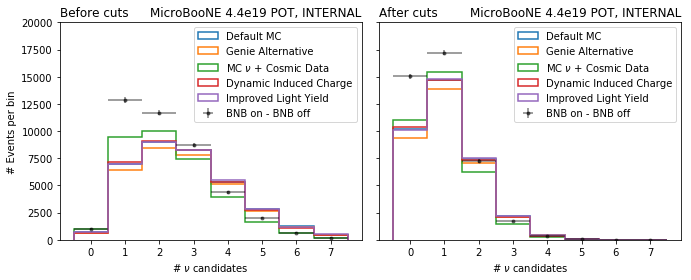

In [31]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharex=True, sharey=True)

N=8
x_min = -0.5
x_max = x_min+N
x_ticks=range(N) 
y_max = 20000

str_after = "flash_PE_max>50"

for sample, df in zip(allnu, df_arr):
    ax[0].hist(df.query(str_after)["n_primaries"],bins=N, range = (x_min, x_max), label=sample[6],
               weights= df.query(str_after)["bnbweight"]*bnb_pot/sample[2], histtype='step', lw=1.5)
    ax[1].hist(df.query(str_after)["passed_primaries"],bins=N, range = (x_min, x_max), label=sample[6],
               weights= df.query(str_after)["bnbweight"]*bnb_pot/sample[2], histtype='step', lw=1.5)
    
bnb_on, _ = np.histogram(data_on.query(str_after)["n_primaries"],bins=N,range=(x_min,x_max))
bnb_off_values = data_off.query(str_after)["n_primaries"]
bnb_off_weights = data_off.query(str_after)["bnbweight"]
bnb_off, _ = np.histogram(bnb_off_values ,bins=N,range=(x_min,x_max), weights=bnb_off_weights) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(bnb_off_values.tolist(),bnb_off_weights.tolist(),range(N+1)))**2)
ax[0].errorbar(x_ticks, bnb_on-bnb_off, xerr=0.5, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")

bnb_on, _ = np.histogram(data_on.query(str_after)["passed_primaries"],bins=N,range=(x_min,x_max))
bnb_off_values = data_off.query(str_after)["passed_primaries"]
bnb_off_weights = data_off.query(str_after)["bnbweight"]
bnb_off, _ = np.histogram(bnb_off_values ,bins=N,range=(x_min,x_max), weights=bnb_off_weights) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(bnb_off_values.tolist(),bnb_off_weights.tolist(),range(N+1)))**2)
ax[1].errorbar(x_ticks, bnb_on-bnb_off, xerr=0.5, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")


ax[0].set_xticks(x_ticks)
ax[0].set_xlabel(r"# $\nu$ candidates")
ax[0].set_ylabel(r"# Events per bin")
ax[0].set_title(r"Before cuts", loc='left')
ax[0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[0].set_ylim(0,20000)
ax[0].legend()

ax[1].set_title(r"After cuts", loc='left')
ax[1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[1].legend()
ax[1].set_xlabel(r"# $\nu$ candidates")

fig.tight_layout(h_pad=0.5)
plt.savefig( outdir+"syst_n_candidates.pdf")

In [40]:
data_off_candidate = pd.read_pickle("./input/df_bnbext_a_flash_candidate.pckl")
data_on_candidate = pd.concat([pd.read_pickle("./input/df_bnb_a_flash_candidate.pckl"),pd.read_pickle("./input/df_bnb_b_flash_candidate.pckl")])

data_off_candidate["bnbweight"] = ext_scale
data_on_candidate["bnbweight"] = 1

diff_z


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


diff_sz
diff_y
diff_sy


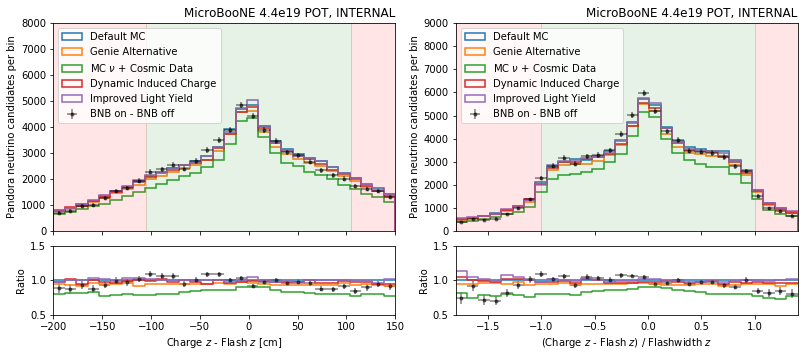

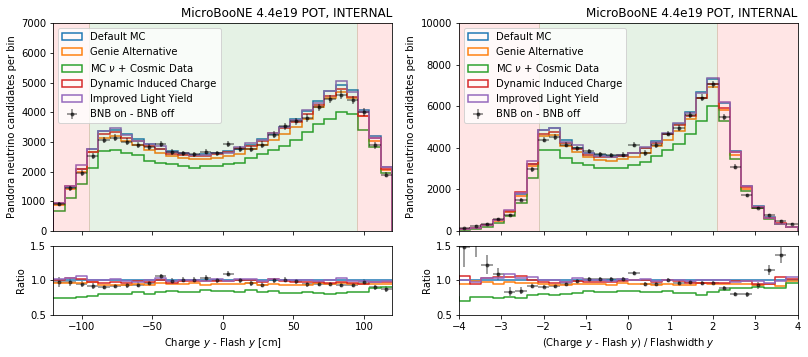

In [48]:
fig1,ax1=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})
fig2,ax2=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})
fig = [fig1,fig2]
ax=[ax1,ax2]

y_r_min=0.5
y_r_max=1.5

str_query = "flash_passed>-3"

x_axis_arr = ["diff_z", "diff_sz", "diff_y", "diff_sy"]
x_label_arr = [r"Charge $z$ - Flash $z$ [cm]", "(Charge $z$ - Flash $z$) / Flashwidth $z$",
               r"Charge $y$ - Flash $y$ [cm]", "(Charge $y$ - Flash $y$) / Flashwidth $y$"]

x_min_arr =  [-200,-1.8,-120,-4.0]
x_max_arr =  [150,1.4,120,4.0]
bins_arr = [30,30,30,30]
y_max_arr = [8000,9000,7000,10000]
cut_arr = [105,1.0,95,2.1]

for i, x_axis, x_label, x_min, x_max, N, y_max, cut in zip(range(len(x_axis_arr)), x_axis_arr, x_label_arr, x_min_arr, x_max_arr, bins_arr, y_max_arr, cut_arr):
    print(x_axis)
    bins_arr= []
    bhalf = (x_max-x_min)/(2*N)
    for sample, df in zip(allnu, df_candidate_arr):
        bins,edges,_ = ax[int(i/2)][0][i%2].hist(df.query(str_query)[x_axis], bins=N, range = (x_min, x_max), histtype='step', 
                                             weights=df.query(str_query)["bnbweight"]*bnb_pot/sample[2], label=sample[6],lw=1.5)
        bins_arr.append(bins)
    
    bnb_on, _ = np.histogram(data_on_candidate.query(str_after)[x_axis],bins=N,range=(x_min,x_max))
    bnb_off_values = data_off_candidate.query(str_after)[x_axis]
    bnb_off_weights = data_off_candidate.query(str_after)["bnbweight"]
    bnb_off, _ = np.histogram(bnb_off_values ,bins=N,range=(x_min,x_max), weights=bnb_off_weights) 
    err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(bnb_off_values.tolist(),bnb_off_weights.tolist(),edges))**2)
    ax[int(i/2)][0][i%2].errorbar(edges[:-1]+bhalf, bnb_on-bnb_off, xerr=bhalf, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")

    ax[int(i/2)][0][i%2].set_title(r"", loc='left')
    ax[int(i/2)][0][i%2].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
    ax[int(i/2)][1][i%2].set_xlabel(x_label)
    ax[int(i/2)][0][i%2].set_xlim(x_min,x_max)
    ax[int(i/2)][0][i%2].set_ylim(0,y_max)
    ax[int(i/2)][0][i%2].set_ylabel("Pandora neutrino candidates per bin")
    ax[int(i/2)][0][i%2].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[int(i/2)][0][i%2].axvspan(-cut,cut, alpha=0.1, color="green")
    ax[int(i/2)][0][i%2].axvspan(cut,x_max, alpha=0.1, color="red")
    
    ax[int(i/2)][0][i%2].legend(loc="upper left")

    ratios = bins_arr/bins_arr[0]
    ax[int(i/2)][1][i%2].errorbar(edges[:-1]+bhalf, (bnb_on-bnb_off)/bins_arr[0], xerr=bhalf, yerr=err_on_off/bins_arr[0] ,alpha=0.5, color= "k", fmt=".")
    for sample, ratio in zip(allnu, ratios):
        ratio = np.append(ratio[1], ratio)
        ax[int(i/2)][1][i%2].plot(edges,ratio,ls='steps')

    ax[int(i/2)][1][i%2].set_ylabel('Ratio')
    ax[int(i/2)][1][i%2].set_ylim(y_r_min,y_r_max)
    
    fig[0].tight_layout(h_pad=0.5)
    fig[0].savefig( outdir+"syst_cuts1.pdf")
    fig[1].tight_layout(h_pad=0.5)
    fig[1].savefig( outdir+"syst_cuts2.pdf")

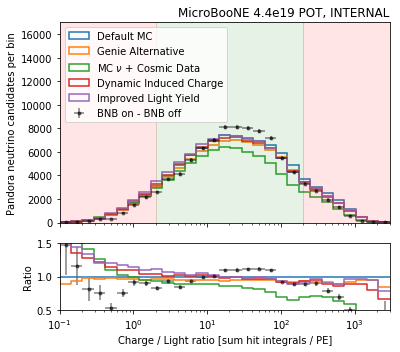

In [53]:
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(3.5*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0.5
y_r_max=1.5
str_query = "flash_passed>-3"

x_min = 0.1
x_max = 3000
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
cut = 3.0
y_max = 17000

x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]

bins_arr= []
for sample, df in zip(allnu, df_candidate_arr):
    bins,edges,_ = ax[0].hist(df.query(str_query)["charge_ratio"], bins=edges, histtype='step', 
                                         weights=df.query(str_query)["bnbweight"]*bnb_pot/sample[2], label=sample[6],lw=1.5)
    bins_arr.append(bins)

bnb_on, _ = np.histogram(data_on_candidate.query(str_after)["charge_ratio"],bins=edges,range=(x_min,x_max))
bnb_off_values = data_off_candidate.query(str_after)["charge_ratio"]
bnb_off_weights = data_off_candidate.query(str_after)["bnbweight"]
bnb_off, _ = np.histogram(bnb_off_values ,bins=edges,range=(x_min,x_max), weights=bnb_off_weights) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(bnb_off_values.tolist(),bnb_off_weights.tolist(),edges))**2)
ax[0].errorbar(edges_mid, bnb_on-bnb_off, xerr=x_err, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")
    
ax[0].set_title(r"", loc='left')
ax[0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[1].set_xlabel(r"Charge / Light ratio [sum hit integrals / PE]")
ax[0].set_ylabel("Pandora neutrino candidates per bin")
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0,y_max)
ax[0].axvspan(x_min,2, alpha=0.1, color="red")
ax[0].axvspan(2,200, alpha=0.1, color="green")
ax[0].axvspan(200,x_max, alpha=0.1, color="red")
ax[0].set_xscale("log", nonposx='clip')  
ax[0].legend(loc="upper left")

ratios = bins_arr/bins_arr[0]
ax[1].errorbar(edges_mid, (bnb_on-bnb_off)/bins_arr[0], xerr=x_err, yerr=err_on_off/bins_arr[0] ,alpha=0.5, color= "k", fmt=".")
for sample, ratio in zip(allnu, ratios):
    ratio = np.append(ratio[1], ratio)
    ax[1].plot(edges,ratio,ls='steps')

ax[1].set_ylabel('Ratio')
ax[1].set_ylim(y_r_min,y_r_max)

fig.tight_layout()
fig.savefig( outdir+"syst_cuts3.pdf")

In [54]:
# From here we have to make 3 more flashmatching plots, they require a slow event loop!

#Data/MC plots
diff_score_arr = []
diff_x_arr = []
score_max_arr = []
hypo_PE_max_arr = []
ratio_hypo_PE_arr = []
weight_arr = []

for df,sample in zip(df_arr,allnu):
    diff_score = []
    diff_x = []
    score_max = []
    hypo_PE_max = []
    ratio_hypo_PE = []
    weight = []
    print(sample[0])
    for index, row in df.iterrows():
        if len(row["flash_score"])>1:
            diff_score.append( row["flash_score"][0]/row["flash_score"][1] )
            score_max.append( row["flash_score"][0])
            diff_x.append( row["TPC_x"][0]-row["flash_x"][0] )
            hypo_PE_max.append( row["flash_hypo_PE"][0])
            ratio_hypo_PE.append( row["flash_hypo_PE"][0]/row["flash_PE_max"])
            weight.append(row["bnbweight"])
            
    weight_arr.append(np.array(weight)*bnb_pot/sample[2])        
    diff_score_arr.append(diff_score)
    diff_x_arr.append(diff_x)
    score_max_arr.append(score_max)
    hypo_PE_max_arr.append(hypo_PE_max)
    ratio_hypo_PE_arr.append(ratio_hypo_PE)
print("done")

nu
nu_tune3
nu_overlaid
nu_induced
nu_lightbug
done


In [55]:
#Data/MC plots
diff_score_on = []
diff_score_off = []
diff_x_on = []
diff_x_off = []
score_max_on = []
score_max_off = []
hypo_PE_max_on = []
hypo_PE_max_off = []
ratio_hypo_PE_on = []
ratio_hypo_PE_off = []
weight_off = []

for index, row in data_on.iterrows():
    if len(row["flash_score"])>1:
        diff_score_on.append( row["flash_score"][0]/row["flash_score"][1] )
        score_max_on.append( row["flash_score"][0])
        diff_x_on.append( row["TPC_x"][0]-row["flash_x"][0] )
        hypo_PE_max_on.append( row["flash_hypo_PE"][0])
        ratio_hypo_PE_on.append( row["flash_hypo_PE"][0]/row["flash_PE_max"])
        
for index, row in data_off.iterrows():
    if len(row["flash_score"])>1:
        diff_score_off.append( row["flash_score"][0]/row["flash_score"][1] )
        score_max_off.append( row["flash_score"][0])
        diff_x_off.append( row["TPC_x"][0]-row["flash_x"][0] )
        hypo_PE_max_off.append( row["flash_hypo_PE"][0])
        ratio_hypo_PE_off.append( row["flash_hypo_PE"][0]/row["flash_PE_max"])
        weight_off.append(row["bnbweight"])

print("done")

done


([array([9.0000e+00, 1.8900e+02, 5.8000e+02, 1.7210e+03, 1.3327e+04,
         2.4725e+04, 2.9730e+03, 5.8100e+02, 1.7600e+02, 3.0000e+01]),
  array([2.7000e+01, 4.0000e+02, 1.1620e+03, 3.5190e+03, 2.7128e+04,
         5.0659e+04, 6.1020e+03, 1.3150e+03, 2.9700e+02, 6.1000e+01]),
  array([1.8000e+01, 1.4600e+02, 4.5300e+02, 1.2030e+03, 5.5820e+03,
         2.3498e+04, 3.7870e+03, 6.7000e+02, 1.4100e+02, 1.9000e+01]),
  array([8.0000e+00, 9.8000e+01, 2.6600e+02, 7.7200e+02, 5.8480e+03,
         1.1268e+04, 1.3310e+03, 2.9500e+02, 8.1000e+01, 2.1000e+01]),
  array([9.0000e+00, 1.1500e+02, 2.5600e+02, 6.9600e+02, 4.0210e+03,
         1.3467e+04, 1.5180e+03, 3.3000e+02, 7.6000e+01, 1.5000e+01])],
 array([-269.92240028, -217.35876429, -164.79512831, -112.23149232,
         -59.66785633,   -7.10422035,   45.45941564,   98.02305163,
         150.58668762,  203.1503236 ,  255.71395959]),
 <a list of 5 Lists of Patches objects>)

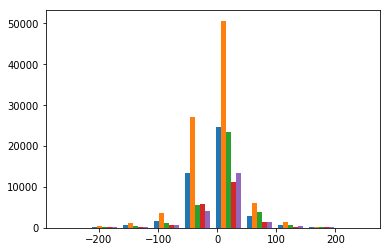

In [15]:
plt.hist(diff_x_arr)

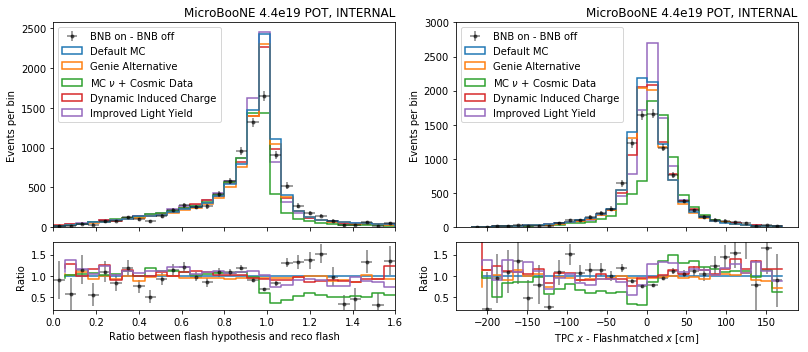

In [67]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0.2
y_r_max=1.8

#left
x_max=1.6
x_min=0
N=30
bhalf = (x_max-x_min)/(2*N)
y_max = 4600
    
bins,edges,_ = ax[0][0].hist(ratio_hypo_PE_arr,bins=N,range=(x_min,x_max), histtype='step', 
                             weights=weight_arr, label=[i[6] for i in allnu],lw=1.5) 

bnb_on, _ = np.histogram(ratio_hypo_PE_on,bins=N,range=(x_min,x_max))
bnb_off, _ = np.histogram(ratio_hypo_PE_off ,bins=N,range=(x_min,x_max), weights=weight_off) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(ratio_hypo_PE_off,weight_off,edges))**2)
ax[0][0].errorbar(edges[:-1]+bhalf, bnb_on-bnb_off, xerr=bhalf, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")

ax[0][0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[1][0].set_xlabel(r"Ratio between flash hypothesis and reco flash")
ax[0][0].set_ylabel(r"Events per bin")
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc="upper left")
ax[0][0].set_xlim(x_min,x_max)

ratios = bins/bins[0]
ax[1][0].errorbar(edges[:-1]+bhalf, (bnb_on-bnb_off)/bins[0], xerr=bhalf, yerr=err_on_off/bins[0] ,alpha=0.5, color= "k", fmt=".")
for sample, ratio in zip(allnu, ratios):
    ax[1][0].plot(edges[1:],ratio,ls='steps')
    
ax[1][0].set_ylabel('Ratio')
ax[1][0].set_ylim(y_r_min,y_r_max)

#right
x_min = -220
x_max = 170
N=30
bhalf = (x_max-x_min)/(2*N)

bins,edges,_ = ax[0][1].hist(diff_x_arr,bins=N,range=(x_min,x_max), histtype='step', 
                             weights=weight_arr, label=[i[6] for i in allnu],lw=1.5) 

bnb_on, _ = np.histogram(diff_x_on,bins=N,range=(x_min,x_max))
bnb_off, _ = np.histogram(diff_x_off ,bins=N,range=(x_min,x_max), weights=weight_off) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(diff_x_off,weight_off,edges))**2)
ax[0][1].errorbar(edges[:-1]+bhalf, bnb_on-bnb_off, xerr=bhalf, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")

ratios = bins/bins[0]
ax[1][1].errorbar(edges[:-1]+bhalf, (bnb_on-bnb_off)/bins[0], xerr=bhalf, yerr=err_on_off/bins[0] ,alpha=0.5, color= "k", fmt=".")
for sample, ratio in zip(allnu, ratios):
    ax[1][1].plot(edges[1:],ratio,ls='steps')
 
ax[0][1].set_ylim(0,3000)
ax[0][1].set_ylabel(r"Events per bin")
ax[1][1].set_ylabel('Ratio')
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlabel(r"TPC $x$ - Flashmatched $x$ [cm]")
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")

fig.tight_layout(h_pad=0.5)
fig.savefig( outdir+"syst_match1.pdf")

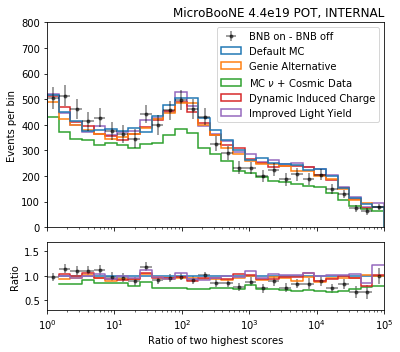

In [71]:
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(3.5*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0.3
y_r_max=1.7

#left
x_min = 1
x_max = 1e5
N=30
y_max=800
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]


bins,edges,_ = ax[0].hist(diff_score_arr,bins=edges, range=(1,1e5), histtype='step', 
                             weights=weight_arr, label=[i[6] for i in allnu],lw=1.5) 

bnb_on, _ = np.histogram(diff_score_on,bins=edges,range=(x_min,x_max))
bnb_off, _ = np.histogram(diff_score_off ,bins=edges,range=(x_min,x_max), weights=weight_off) 
err_on_off = np.sqrt ( bnb_on + np.array(hist_bin_uncertainty(diff_score_off,weight_off,edges))**2)
ax[0].errorbar(edges_mid, bnb_on-bnb_off, xerr=x_err, yerr=err_on_off,alpha=0.5, color= "k",fmt=".",label="BNB on - BNB off")

ax[0].set_xscale("log", nonposx='clip')
ax[0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[0].set_ylabel(r"Events per bin")
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1],loc="upper right")
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0,y_max)

ax[1].set_xlabel(r"Ratio of two highest scores")
ratios = bins/bins[0]
ax[1].errorbar(edges_mid, (bnb_on-bnb_off)/bins[0], xerr=x_err, yerr=err_on_off/bins[0] ,alpha=0.5, color= "k", fmt=".")
for sample, ratio in zip(allnu, ratios):
    ax[1].plot(edges[1:],ratio,ls='steps')   
ax[1].set_ylabel('Ratio')
ax[1].set_ylim(y_r_min,y_r_max)

fig.tight_layout(h_pad=0.5)
fig.savefig( outdir+"syst_match2.pdf")